# Efficient Causal Inference from Combined Observational and Interventional Data through Causal Reductions

This notebook contains a step-by-step explanation of the implementation of our paper "Efficient Causal Inference from Combined Observational and Interventional Data through Causal Reductions" https://arxiv.org/abs/2103.04786. **THIS NOTEBOOK DOES NOT REPRODUCE THE EXACT RESULTS OF THE PAPER.** The other code in the Github repository does.

This notebook assumes no prior knowledge about Github, Google Colab, or Pytorch/Pyro.

We will heavily rely on the Python modules Pytorch and Pyro for the implementation, the latter provides us with a very clean API for working with normalizing flows and distributions in general. E.g. each distribution is its own object with very useful functions like .sample() or .log_prob().

**One warning for first-time users of notebooks**: After you changed the content of a cell, you have to rerun it!

In [21]:
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt

In [22]:
!pip3 install pyro-ppl 
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
from pyro.nn import DenseNN

# Getting the data from Github

Please download the data we have simulated for our paper here:
https://github.com/max-ilse/CausalReduction

To download the data click on the green box that says code and choose download zip. Now go to the downloaded zip folder and unzip it.

To upload the data to this notebook, you have to click on the folder icon on the left of the page. You now see three icons on top. The first one lets you upload the data you downloaded from Github. Go ahead and upload the dataset.pkl files.

In the following box, you can choose which dataset to use.


In [23]:
# Choose dataset and seed for the rest of the notebook
dataset_number = 8
seed = 0 # the seed controls the train, validation, test split of the data
# as well as the initialization of the flows

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# get data from .pkl
name = 'dataset' + str(dataset_number)
with open(name + '.pkl', 'rb') as f:
    save_dict = pickle.load(f)

y_obser = save_dict['y_obser']
x_obser = save_dict['x_obser']
y_inter = save_dict['y_inter']
x_inter = save_dict['x_inter']

# # Shuffle data
p = np.random.permutation(len(y_obser))
x_obser = x_obser[p]
y_obser = y_obser[p]
x_inter = x_inter[p]
y_inter = y_inter[p]

# from numpy to torch, the standard object in pytorch is a tensor, you will see
# us going back and forth between tensors and arrays a lot in this notebook
x_obser = torch.Tensor(x_obser)
y_obser = torch.Tensor(y_obser)
x_inter = torch.Tensor(x_inter)
y_inter = torch.Tensor(y_inter)


Each dataset consists of 3000 observational and 3000 interventional samples. You can now choose how many interventional and observational samples to choose for training, validation, and testing. In our paper, we assume that we have as many validation samples as we have training samples. Furthermore, we always use 1000 samples for testing.

In [24]:
# Split in train, val, test
train_len_obser = 1000
train_len_inter = 100
val_len_obser = train_len_obser
val_len_inter = train_len_inter 
test_len = 1000

x_obser_train = x_obser[:train_len_obser]
y_obser_train = y_obser[:train_len_obser]
x_inter_train = x_inter[:train_len_inter]
y_inter_train = y_inter[:train_len_inter]

x_obser_val = x_obser[train_len_obser:train_len_obser + val_len_obser]
y_obser_val = y_obser[train_len_obser:train_len_obser + val_len_obser]
x_inter_val = x_inter[train_len_inter:train_len_inter + val_len_inter]
y_inter_val = y_inter[train_len_inter:train_len_inter + val_len_inter]

x_obser_test = x_obser[-test_len:]
y_obser_test = y_obser[-test_len:]
x_inter_test = x_inter[-test_len:]
y_inter_test = y_inter[-test_len:]


To get an idea how the data looks like we visualize all 3000 observational and 3000 interventional samples. In addition, we plot the training samples that were selected in the cell above. 

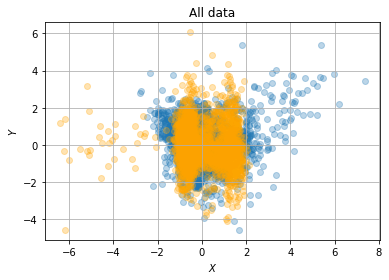

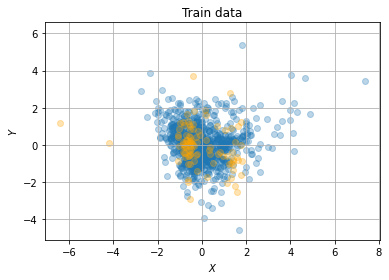

In [25]:
# Plot all data
plt.figure()
plt.scatter(x_obser, y_obser, alpha=0.3)
plt.scatter(x_inter, y_inter, c='orange', alpha=0.3)
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('All data')
plt.grid()
# save axis for next plot
x_min_max = plt.xlim()
y_min_max = plt.ylim()
plt.show()

plt.figure()
plt.scatter(x_obser_train, y_obser_train, alpha=0.3)
plt.scatter(x_inter_train, y_inter_train, c='orange', alpha=0.3)
plt.xlim(x_min_max)
plt.ylim(y_min_max)
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Train data')
plt.grid()
plt.show()

# Flows

We will now start to build normalizing flows. The Python module Pyro lets us build flows with very little code, which makes the code very readable. It also helps that we use one-dimensional data.

We choose a special type of flow called linear rational spline flows (https://arxiv.org/abs/2001.05168).

As written in the Pyro documentation: "Rational splines offer an excellent combination of functional flexibility whilst maintaining a numerically stable inverse that is of the same computational and space complexities as the forward operation. This element-wise transform permits the accurate representation of complex univariate distributions."

First, we have to make a small adjustment to one function in Pyro. If we call the log_prob function of a flow object we want it to return the log probability as well as the transformed input.

In [26]:
def _sum_rightmost(value, dim):
    r"""
    Sum out ``dim`` many rightmost dimensions of a given tensor.

    Args:
        value (Tensor): A tensor of ``.dim()`` at least ``dim``.
        dim (int): The number of rightmost dims to sum out.
    """
    if dim == 0:
        return value
    required_shape = value.shape[:-dim] + (-1,)
    return value.reshape(required_shape).sum(-1)


def log_prob_new(self, value):
    """
    Scores the sample by inverting the transform(s) and computing the score
    using the score of the base distribution and the log abs det jacobian.
    """
    event_dim = len(self.event_shape)
    log_prob = 0.0
    y = value
    for transform in reversed(self.transforms):
        x = transform.inv(y)
        log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                event_dim - transform.event_dim)
        y = x

    log_prob = log_prob + _sum_rightmost(self.base_dist.log_prob(y),
                                            event_dim - len(self.base_dist.event_shape))
    return log_prob, y


dist.TransformedDistribution.log_prob = log_prob_new

We start with the non-conditional flow $u = f_\phi(x)$. Since we are using linear rational spline flows we have to choose two hyperparameters first. The number of bins our function will be divided into and the range of $x$.

Following the change of variable formula, we then define a simple base distribution (a standard normal) and a transformation. Pyro will take care of the rest, especially the computation of the Jacobian. The final loss is given by

$\log p(x) = \log p_U(f_{\phi}(x)) + \log \left\lvert \frac{\delta f_{\phi}(x)}{\delta x} \right\lvert$.



In [27]:
# Choose hyperparameters
num_spline_bins = 32
spline_bounds = 6.0

# Build model spline model
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
spline_transform = T.Spline(1, count_bins=num_spline_bins, bound=spline_bounds)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])


In our experiments, we found it useful to pretrain the non-conditional flow first before combining it with the second, conditional flow.

We now define a train and a test function for the non-conditional flow.

In [28]:
def train_obser(model, optimizer, x_obser):
    model.transforms[0].train()

    optimizer.zero_grad()
    loss, _ = model.log_prob(x_obser)
    loss = -loss.mean()
    loss.backward()
    optimizer.step()
    model.clear_cache()

    return loss.item()


def test_obser(model, x_obser):
    model.transforms[0].eval()

    with torch.no_grad():
        loss, _ = model.log_prob(x_obser)
        loss = -loss.mean().item()
        model.clear_cache()

    return loss

Since we are relying on gradient updates for learning we need to define an optimizer. We use Adam.

In [29]:
modules = torch.nn.ModuleList([spline_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=1e-2)

We can now define a training loop and train the non-conditional flow until convergence using observational data.

In [30]:
for itr in range(1, 1000 + 1):
    loss_flow_train_obser = train_obser(flow_dist, optimizer, x_obser_train)
    loss_flow_val_obser = test_obser(flow_dist, x_obser_val)

    print('Epoch: {},'
            ' Observational train flow loss: {},'
            ' Observational val flow loss: {},'
            .format(itr,
                    loss_flow_train_obser,
                    loss_flow_val_obser))

Epoch: 1, Observational train flow loss: 4.579110145568848, Observational val flow loss: 4.298532009124756,
Epoch: 2, Observational train flow loss: 4.178235054016113, Observational val flow loss: 3.957772970199585,
Epoch: 3, Observational train flow loss: 3.984970808029175, Observational val flow loss: 3.7441458702087402,
Epoch: 4, Observational train flow loss: 3.7135539054870605, Observational val flow loss: 3.5103445053100586,
Epoch: 5, Observational train flow loss: 3.4359514713287354, Observational val flow loss: 3.237572193145752,
Epoch: 6, Observational train flow loss: 3.2642476558685303, Observational val flow loss: 3.0306265354156494,
Epoch: 7, Observational train flow loss: 3.085482358932495, Observational val flow loss: 2.8757402896881104,
Epoch: 8, Observational train flow loss: 2.980318546295166, Observational val flow loss: 2.8239848613739014,
Epoch: 9, Observational train flow loss: 2.9383111000061035, Observational val flow loss: 2.6665987968444824,
Epoch: 10, Observa

The second flow we are using is a conditional flow $v = g_{x,u ; \theta}$. In contrast to the non-conditional flow above we now use a small neural network to transform the inputs $x,u$. The parameters of the neural network are jointly updated with parameters of the flow.

In [31]:
# Choose hyperparameters
num_spline_bins = 32
spline_bounds = 6.0
input_dim = 1
context_dim = 2

# Build conditional spline model
base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
param_dims = [input_dim * num_spline_bins, input_dim * num_spline_bins,
                input_dim * (num_spline_bins - 1), input_dim * num_spline_bins]
hypernet = DenseNN(context_dim, [50, 50], param_dims)
conditional_spline_transform = T.ConditionalSpline(hypernet, input_dim, num_spline_bins, bound=spline_bounds)
conditional_flow_dist = dist.ConditionalTransformedDistribution(base_dist, [conditional_spline_transform])


The conditional flow will be jointly trained using observational and interventional data. In the case of observational data we use the following loss function

$\log p(y|x) = \log p_V(g_{x,u; \theta}(y)) + \log \left\lvert \frac{\delta g_{x, u; \theta}(y)}{\delta y} \right\lvert.$

In the case of interventional data, the loss function is given by

$ \log p(y|\text{do}(x)) = \log \int p_V(g_{x,u; \theta}(y)) \left\lvert \frac{\delta g_{x, u; \theta}(y)}{\delta y} \right\lvert p(u) du,$

where we use numerical integration to approximate the integral.


In [32]:
def conditional_train_obser(flow_dist, conditional_flow_dist, optimizer, x_obser, y_obser):
    flow_dist.transforms[0].train()
    conditional_flow_dist.transforms[0].train()

    # get u_flow and log prob
    optimizer.zero_grad()
    loss_flow, u_flow = flow_dist.log_prob(x_obser)
    loss_flow = -loss_flow.mean()

    # x, y and u_flow into conditional flow, get log prob
    x_obser_u_flow = torch.cat([x_obser, u_flow], dim=1)
    conditional_dist = conditional_flow_dist.condition(x_obser_u_flow.detach())
    loss_cond_flow, _ = conditional_dist.log_prob(y_obser.detach())
    loss_cond_flow = -loss_cond_flow.mean()

    loss = loss_flow + loss_cond_flow

    loss.backward()
    optimizer.step()
    conditional_flow_dist.clear_cache()
    flow_dist.clear_cache()

    return loss_flow.item(), loss_cond_flow.item()


def conditional_test_obser(flow_dist, conditional_flow_dist, x_obser, y_obser):
    flow_dist.transforms[0].eval()
    conditional_flow_dist.transforms[0].eval()

    with torch.no_grad():
        # get u_flow and log prob
        loss_flow, u_flow = flow_dist.log_prob(x_obser)
        loss_flow = -loss_flow.mean()

        # x, y and u_flow into conditional flow, get log prob
        x_obser_u_flow = torch.cat([x_obser, u_flow], dim=1)
        conditional_dist = conditional_flow_dist.condition(x_obser_u_flow.detach())
        loss_cond_flow, _ = conditional_dist.log_prob(y_obser.detach())
        loss_cond_flow = -loss_cond_flow.mean()

        conditional_flow_dist.clear_cache()
        flow_dist.clear_cache()

        return loss_flow.item(), loss_cond_flow.item()

def conditional_train_inter_integral(model, optimizer, x_inter, y_inter, integral_points):
    model.transforms[0].train()

    input_shape = y_inter.shape[0]
    u = np.linspace(-15, 15, integral_points)
    u = torch.Tensor(u)
    u_repeat = u.repeat(1, input_shape).view(input_shape * integral_points, 1)

    # Repeat so we can later trapz along one dimension
    x = x_inter.repeat(1, integral_points).view(input_shape * integral_points, 1)
    y = y_inter.repeat(1, integral_points).view(input_shape * integral_points, 1)

    x_u = torch.cat([x, u_repeat], dim=1)

    optimizer.zero_grad()
    ln_p_y_given_x_and_u, _ = model.condition(x_u.detach()).log_prob(y.detach())

    # Get ready for integration
    p_y_given_x_and_u = torch.exp(ln_p_y_given_x_and_u)
    pi = torch.Tensor((np.pi,))
    pu = 1 / torch.sqrt((2 * pi)) * torch.exp(-0.5 * (u_repeat ** 2))
    p_y_given_x_and_u_times_pu = p_y_given_x_and_u * pu
    p_y_given_x_and_u_times_pu = p_y_given_x_and_u_times_pu.view(input_shape, integral_points)

    # Integrate along u
    integral = torch.trapz(p_y_given_x_and_u_times_pu, u, dim=-1) + 10e-7  # add noise for stability

    loss = -torch.log(integral).mean()
    loss.backward()

    optimizer.step()
    model.clear_cache()

    return loss.item()


def conditional_test_inter_integral(model, x_inter, y_inter, integral_points):
    model.transforms[0].eval()

    with torch.no_grad():
        input_shape = y_inter.shape[0]
        u = np.linspace(-15, 15, integral_points)
        u = torch.Tensor(u)
        u_repeat = u.repeat(1, input_shape).view(input_shape * integral_points, 1)

        # Repeat so we can later trapz along one dimension
        x = x_inter.repeat(1, integral_points).view(input_shape * integral_points, 1)
        y = y_inter.repeat(1, integral_points).view(input_shape * integral_points, 1)

        x_u = torch.cat([x, u_repeat], dim=1)

        ln_p_y_given_x_and_u, _ = model.condition(x_u.detach()).log_prob(y.detach())

        # Get ready for integration
        p_y_given_x_and_u = torch.exp(ln_p_y_given_x_and_u)
        pi = torch.Tensor((np.pi,))
        pu = 1 / torch.sqrt((2 * pi)) * torch.exp(-0.5 * (u_repeat ** 2))
        p_y_given_x_and_u_times_pu = p_y_given_x_and_u * pu
        p_y_given_x_and_u_times_pu = p_y_given_x_and_u_times_pu.view(input_shape, integral_points)

        # Integrate along u
        integral = torch.trapz(p_y_given_x_and_u_times_pu, u, dim=-1) + 10e-7  # add noise for stability

        loss = -torch.log(integral).mean()
        model.clear_cache()

        return loss.item()

Again, we need to define an optimizer.

In [33]:
modules = torch.nn.ModuleList([spline_transform, conditional_spline_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=1e-4)

Now we are ready for the final training loop. Depending on the number of interventional samples the training might take a few minutes.

In [34]:
integral_points = 100

for itr in range(1, 250 + 1):
    loss_flow_train_obser, loss_cond_flow_train_obser = conditional_train_obser(flow_dist,
                                                                                conditional_flow_dist,
                                                                                optimizer, x_obser_train,
                                                                                y_obser_train)
    loss_cond_flow_train_inter = conditional_train_inter_integral(conditional_flow_dist, optimizer,
                                                                    x_inter_train,
                                                                    y_inter_train,
                                                                    integral_points)

    loss_flow_val_obser, loss_cond_flow_val_obser = conditional_test_obser(flow_dist, conditional_flow_dist,
                                                                            x_obser_val, y_obser_val)
    loss_cond_flow_val_inter = conditional_test_inter_integral(conditional_flow_dist, x_inter_val,
                                                                y_inter_val, integral_points)

    print('Epoch: {},'
            ' Observational train flow loss: {},'
            ' Observational train cond flow loss: {},'
            ' Interventional train cond flow loss: {},'
            ' Observational val flow loss: {},'
            ' Observational val cond flow loss: {},'
            ' Interventional val cond flow loss: {}'
            .format(itr,
                    loss_flow_train_obser,
                    loss_cond_flow_train_obser,
                    loss_cond_flow_train_inter,
                    loss_flow_val_obser,
                    loss_cond_flow_val_obser,
                    loss_cond_flow_val_inter))

Epoch: 1, Observational train flow loss: 1.2966482639312744, Observational train cond flow loss: 1.5308222770690918, Interventional train cond flow loss: 1.5241119861602783, Observational val flow loss: 1.2900798320770264, Observational val cond flow loss: 1.4464466571807861, Interventional val cond flow loss: 1.491309404373169
Epoch: 2, Observational train flow loss: 1.2965303659439087, Observational train cond flow loss: 1.5266356468200684, Interventional train cond flow loss: 1.521149754524231, Observational val flow loss: 1.2899467945098877, Observational val cond flow loss: 1.4455173015594482, Interventional val cond flow loss: 1.490584373474121
Epoch: 3, Observational train flow loss: 1.296474575996399, Observational train cond flow loss: 1.523616075515747, Interventional train cond flow loss: 1.5181374549865723, Observational val flow loss: 1.2898861169815063, Observational val cond flow loss: 1.4447917938232422, Interventional val cond flow loss: 1.489844560623169
Epoch: 4, Obs

After training, we calculate the log-likelihood on the observational and on the interventional test set.

In [35]:
_, loss_cond_flow_test_obser = conditional_test_obser(flow_dist, conditional_flow_dist, x_obser_test, y_obser_test)
loss_cond_flow_test_inter = conditional_test_inter_integral(conditional_flow_dist, x_inter_test, y_inter_test, integral_points)

print('Observational test log likelihood:', loss_cond_flow_test_obser, 'Interventional test log likelihood:', loss_cond_flow_test_inter)

Observational test log likelihood: 1.3057852983474731 Interventional test log likelihood: 1.3716362714767456


In addition, to the quantitative results above we will look at some qualitative results. After training, we can generate observational and interventional samples from our model given $x$. The sampling procedure for observational samples is

1. $v \sim \mathcal{N}(0,1)$
2. $u = f_\phi(x_o)$
3. $y_o = g_{x_o, u; \theta}^{-1}(v)$

For interventional samples, we have the following steps

1. $v \sim \mathcal{N}(0,1)$ and $u \sim \mathcal{N}(0,1)$
2. $y_i = g_{x_i, u; \theta}^{-1}(v)$

We compare the generated sampled with the original training samples.

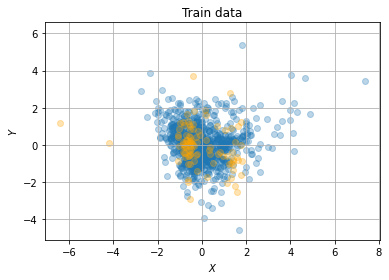

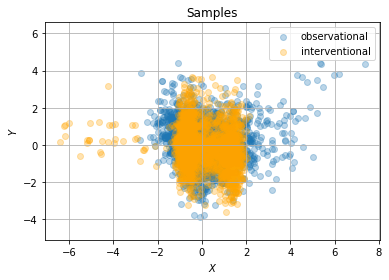

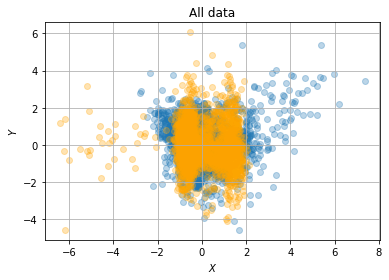

In [36]:
# Choose values to condition on
x_obser_sample = torch.Tensor(x_obser)
x_inter_sample = torch.Tensor(x_inter)

# Sample from observational model
normal = dist.Normal(torch.zeros(3000), torch.ones(3000))
v_sample = normal.sample().unsqueeze(-1)

with torch.no_grad():
    u_sample = spline_transform.inv(x_obser_sample)

    x_obser_u_sample = torch.cat([x_obser_sample, u_sample], dim=-1)
    y_obser_sample = conditional_spline_transform.condition(x_obser_u_sample.detach())(v_sample)

# Sample from interventional model
normal = dist.Normal(torch.zeros(3000), torch.ones(3000))
u_sample = normal.sample().unsqueeze(-1)
v_sample = normal.sample().unsqueeze(-1)

with torch.no_grad():
    x_inter_u_sample = torch.cat([x_inter_sample, u_sample], dim=-1)
    y_inter_sample = conditional_spline_transform.condition(x_inter_u_sample.detach())(v_sample)

# Plot train data for comparison
plt.figure()
plt.scatter(x_obser_train, y_obser_train, alpha=0.3)
plt.scatter(x_inter_train, y_inter_train, c='orange', alpha=0.3)
plt.xlim(x_min_max)
plt.ylim(y_min_max)
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Train data')
plt.grid()
plt.show()

# Plot samples from trained model
plt.figure()
plt.scatter(x_obser_sample, y_obser_sample, alpha=0.3, label='observational')
plt.scatter(x_inter_sample, y_inter_sample, alpha=0.3, color='orange', label='interventional')
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.xlim(x_min_max)
plt.ylim(y_min_max)
plt.title('Samples')
plt.grid()
plt.legend()

# Plot all data for comparison
plt.figure()
plt.scatter(x_obser, y_obser, alpha=0.3)
plt.scatter(x_inter, y_inter, c='orange', alpha=0.3)
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('All data')
plt.grid()
plt.show()

Last, we test if $u$ and $v$ are indeed independent.

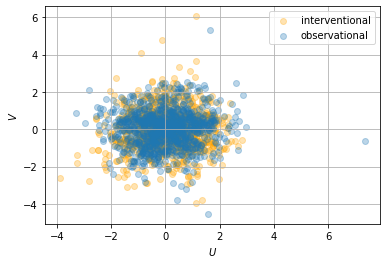

In [37]:
# Choose some data
x_obser_sample = torch.Tensor(x_obser[:1000])
y_obser_sample = torch.Tensor(y_obser[:1000])
x_inter_sample = torch.Tensor(x_inter[:1000])
y_inter_sample = torch.Tensor(y_inter[:1000])

# U and v from observational
with torch.no_grad():
    u_sample_obser = spline_transform.inv(x_obser_sample)

    x_obser_u_sample = torch.cat([x_obser_sample, u_sample_obser], dim=-1)
    v_sample_obser = conditional_spline_transform.condition(x_obser_u_sample.detach()).inv(y_obser_sample)

# U and v from interventional
normal = dist.Normal(torch.zeros(1000), torch.ones(1000))
u_sample_inter = normal.sample().unsqueeze(-1)

with torch.no_grad():
    x_inter_u_sample = torch.cat([x_inter_sample, u_sample_inter], dim=-1)
    v_sample_inter = conditional_spline_transform.condition(x_inter_u_sample.detach()).inv(y_inter_sample)

# Plot u vs v
plt.figure()
plt.scatter(u_sample_inter, v_sample_inter, alpha=0.3, color='orange', label='interventional')
plt.scatter(u_sample_obser, v_sample_obser, alpha=0.3, label='observational')
plt.xlabel('$U$')
plt.ylabel('$V$')
plt.legend()
plt.grid()
plt.show()